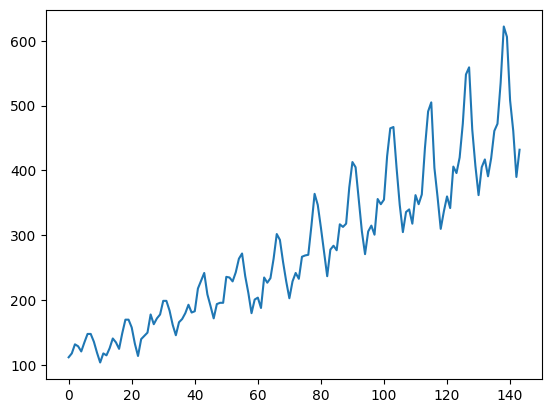

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
 
df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')
 
plt.plot(timeseries)
plt.show()

In [2]:

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [3]:
import torch
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [5]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1, 1])


In [12]:
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
x, _ = self.lstm(x)
# extract only the last time step
x = x[:, -1, :]
x = self.linear(x)

NameError: name 'self' is not defined

In [13]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super(AirModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        # Pass the input through the LSTM layer
        x, _ = self.lstm(x)
        
        # Extract only the last time step from the LSTM output
        x = x[:, -1, :]
        
        # Pass the last time step output through the linear layer
        x = self.linear(x)
        
        return x


In [14]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

C:\Users\88017\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\88017\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([7, 1, 1])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\88017\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([95, 1, 1])) that is different to the input size (torch.Size([95, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch 0: train RMSE 226.0028, test RMSE 422.4086
Epoch 100: train RMSE 187.1597, test RMSE 381.7777
Epoch 200: train RMSE 155.6860, test RMSE 347.9322
Epoch 300: train RMSE 128.0079, test RMSE 316.7466
Epoch 400: train RMSE 104.8075, test RMSE 288.2668
Epoch 500: train RMSE 87.3001, test RMSE 262.9539
Epoch 600: train RMSE 76.6536, test RMSE 241.9469
Epoch 700: train RMSE 72.2867, test RMSE 227.0754
Epoch 800: train RMSE 71.2731, test RMSE 219.0335
Epoch 900: train RMSE 71.1569, test RMSE 216.0883
Epoch 1000: train RMSE 71.3854, test RMSE 214.1426
Epoch 1100: train RMSE 71.3833, test RMSE 211.9731
Epoch 1200: train RMSE 71.3023, test RMSE 210.4470
Epoch 1300: train RMSE 71.3670, test RMSE 209.7018
Epoch 1400: train RMSE 71.3868, test RMSE 209.1036
Epoch 1500: train RMSE 71.4446, test RMSE 208.9290
Epoch 1600: train RMSE 71.4944, test RMSE 209.0045
Epoch 1700: train RMSE 71.4186, test RMSE 208.4479
Epoch 1800: train RMSE 71.4599, test RMSE 208.2890
Epoch 1900: train RMSE 71.4528, test R

In [15]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()


IndexError: too many indices for tensor of dimension 2

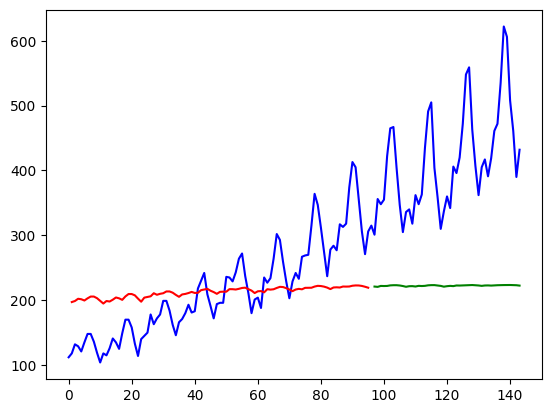

In [17]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    
    # Get the predictions for training data
    y_pred_train = model(X_train)
    
    # If the output is 3D, extract the last time step
    if y_pred_train.dim() == 3:
        y_pred_train = y_pred_train[:, -1, :]
    
    # Reshape y_pred_train to match the shape of train_plot slice
    y_pred_train = y_pred_train.squeeze().reshape(-1, 1)
    
    # Assign the reshaped predictions to the appropriate section of train_plot
    train_plot[lookback:train_size] = y_pred_train
    
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    
    # Get the predictions for test data
    y_pred_test = model(X_test)
    
    # Check if the output is 3D, extract the last time step
    if y_pred_test.dim() == 3:
        y_pred_test = y_pred_test[:, -1, :]
    
    # Reshape y_pred_test to match the shape of test_plot slice
    y_pred_test = y_pred_test.squeeze().reshape(-1, 1)
    
    # Assign the reshaped predictions to the appropriate section of test_plot
    test_plot[train_size+lookback:len(timeseries)] = y_pred_test

# plot
plt.plot(timeseries, c='b')  # Original time series
plt.plot(train_plot, c='r')  # Train predictions in red
plt.plot(test_plot, c='g')   # Test predictions in green
plt.show()


Epoch 0: train RMSE 225.5522, test RMSE 424.7729
Epoch 100: train RMSE 177.9711, test RMSE 374.8650
Epoch 200: train RMSE 141.9658, test RMSE 335.5081
Epoch 300: train RMSE 112.4584, test RMSE 300.5914
Epoch 400: train RMSE 90.3232, test RMSE 270.3319
Epoch 500: train RMSE 68.0976, test RMSE 236.6382
Epoch 600: train RMSE 53.6339, test RMSE 209.2815
Epoch 700: train RMSE 43.2398, test RMSE 185.4467
Epoch 800: train RMSE 35.8861, test RMSE 164.4876
Epoch 900: train RMSE 30.9654, test RMSE 146.4114
Epoch 1000: train RMSE 27.3647, test RMSE 130.5112
Epoch 1100: train RMSE 25.1245, test RMSE 118.3561
Epoch 1200: train RMSE 23.6183, test RMSE 108.4352
Epoch 1300: train RMSE 23.1617, test RMSE 100.2314
Epoch 1400: train RMSE 21.8210, test RMSE 93.7872
Epoch 1500: train RMSE 21.2153, test RMSE 89.1893
Epoch 1600: train RMSE 20.7768, test RMSE 85.0965
Epoch 1700: train RMSE 20.6577, test RMSE 81.5982
Epoch 1800: train RMSE 20.2345, test RMSE 79.8549
Epoch 1900: train RMSE 20.0127, test RMSE 77

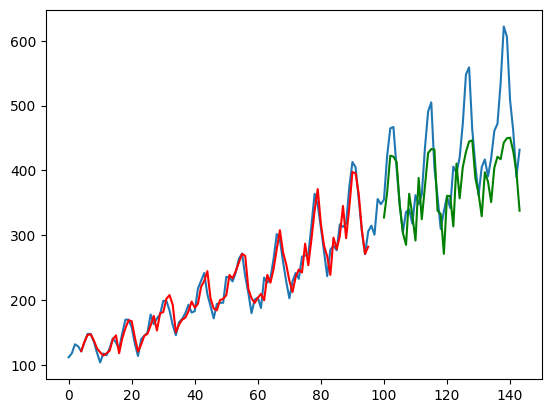

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
 
df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')
 
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)
 
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
 
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()
